# Der kürzeste Weg

Open in Colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/febse/opt2025-de/blob/main/Shortest-Path.ipynb)


Ein Fahrer muss einen Weg von A nach G finden. Dabei gibt es verschiedene Möglichkeiten, wie er fahren kann. Der Fahrer möchte den kürzesten Weg finden. Wir wollen ein lineares Modell formulieren, das dieses Problem löst. 


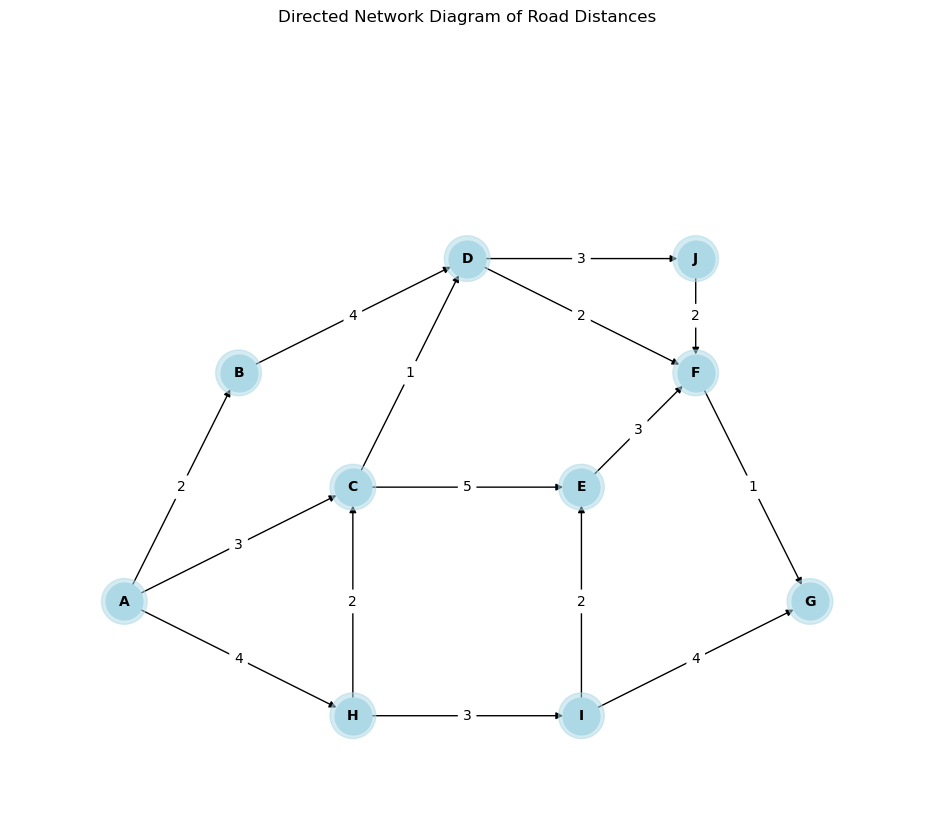

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np

# Create a new directed graph
G = nx.DiGraph()

# Add nodes with positions
positions = {
    'A': (0, 0),
    'B': (1, 2),
    'C': (2, 1),
    'D': (3, 3),
    'E': (4, 1),
    'F': (5, 2),
    'G': (6, 0),
    'H': (2, -1),
    'I': (4, -1),
    'J': (5, 3)
}

# Add edges with weights
edges = [
    ('A', 'B', 2, 0.001),
    ('A', 'C', 3, 0.002),
    ('B', 'D', 4, 0.003),
    ('C', 'D', 1, 0.001),
    ('C', 'E', 5, 0.001),
    ('D', 'F', 2, 0.005),
    ('E', 'F', 3, 0.002),
    ('F', 'G', 1, 0.010),
    ('A', 'H', 4, 0.008),
    ('H', 'C', 2, 0.006),
    ('H', 'I', 3, 0.002),
    ('I', 'E', 2, 0.001),
    ('I', 'G', 4, 0.002),
    ('D', 'J', 3, 0.002),
    ('J', 'F', 2, 0.008)
]

# Add the edges to the graph
for u, v, w, prob in edges:
    G.add_edge(u, v, Distance=w, Probability=prob)

# Draw the updated graph
plt.figure(figsize=(10, 8))
nx.draw(G, pos=positions, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'Distance')

nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels, rotate=False)

# Draw circles around nodes
for node, (x, y) in positions.items():
    circle = mpatches.Circle((x, y), radius=0.2, color='lightblue', alpha=0.5)
    plt.gca().add_patch(circle)

# Set limits and aspect
plt.xlim(-1, 7)
plt.ylim(-2, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Directed Network Diagram of Road Distances')
plt.grid()
plt.show()

In [3]:
# Create a pandas DataFrame to store the edges and their attributes

import pandas as pd
# Create a DataFrame from the edges list
dt = pd.DataFrame(edges, columns=['Source', 'Target', 'Distance', 'Probability']).set_index(['Source', 'Target'])
# Display the DataFrame

dt

Distance  Probability
Source Target                       
A      B              2        0.001
       C              3        0.002
B      D              4        0.003
C      D              1        0.001
       E              5        0.001
D      F              2        0.005
E      F              3        0.002
F      G              1        0.010
A      H              4        0.008
H      C              2        0.006
       I              3        0.002
I      E              2        0.001
       G              4        0.002
D      J              3        0.002
J      F              2        0.008

In [4]:
# Get all unique values from a multiindex
def get_unique_values(df):
    # Get the unique values from the multiindex
    unique_values = set()
    for index in df.index:
        unique_values.update(index)
    return unique_values

nodes = get_unique_values(dt)

nodes

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'}

In [5]:
# A gurobi optimization model for the shortest path problem

import gurobipy as gp
from gurobipy import GRB

# Create a new model
m = gp.Model("ShortestPath")

# Create variables for each edge
x = m.addVars(dt.index, vtype=GRB.BINARY, name="x")

# Set the objective function to minimize the total distance
m.setObjective(x.prod(dt['Distance'].to_dict()), GRB.MINIMIZE)

# Add constraints to ensure that the flow conservation is satisfied

# For each node, the flow into the node must equal the flow out of the node

for node in nodes:
    if node == 'A':  # Source node
        m.addConstr(x.sum(node, '*') - x.sum('*', node) == 1, name=f"source_{node}")
    elif node == 'G':  # Sink node
        m.addConstr(x.sum('*', node) - x.sum(node, '*') == 1, name=f"sink_{node}")
    else:
        m.addConstr(x.sum(node, '*') - x.sum('*', node) == 0, name=f"flow_{node}")
# Add constraints to ensure that the flow is binary

m.write("shortest_path.lp")

with open("shortest_path.lp", "r") as file:
    print(file.read())

m.optimize()

Restricted license - for non-production use only - expires 2026-11-23
\ Model ShortestPath
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
  2 x[A,B] + 3 x[A,C] + 4 x[B,D] + x[C,D] + 5 x[C,E] + 2 x[D,F] + 3 x[E,F]
   + x[F,G] + 4 x[A,H] + 2 x[H,C] + 3 x[H,I] + 2 x[I,E] + 4 x[I,G]
   + 3 x[D,J] + 2 x[J,F]
Subject To
 source_A: x[A,B] + x[A,C] + x[A,H] = 1
 flow_I: - x[H,I] + x[I,E] + x[I,G] = 0
 flow_E: - x[C,E] + x[E,F] - x[I,E] = 0
 flow_D: - x[B,D] - x[C,D] + x[D,F] + x[D,J] = 0
 flow_B: - x[A,B] + x[B,D] = 0
 flow_F: - x[D,F] - x[E,F] + x[F,G] - x[J,F] = 0
 flow_C: - x[A,C] + x[C,D] + x[C,E] - x[H,C] = 0
 flow_H: - x[A,H] + x[H,C] + x[H,I] = 0
 sink_G: x[F,G] + x[I,G] = 1
 flow_J: - x[D,J] + x[J,F] = 0
Bounds
Binaries
 x[A,B] x[A,C] x[B,D] x[C,D] x[C,E] x[D,F] x[E,F] x[F,G] x[A,H] x[H,C]
 x[H,I] x[I,E] x[I,G] x[D,J] x[J,F]
End

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Core(TM) i9-14

In [6]:
# Print the results

if m.status == GRB.OPTIMAL:
    print('Optimal solution found:')
    for v in m.getVars():
        if v.x > 0:
            print(f'{v.varName}: {v.x}')
    else:
        print('No optimal solution found.')


Optimal solution found:
x[A,C]: 1.0
x[C,D]: 1.0
x[D,F]: 1.0
x[F,G]: 1.0
No optimal solution found.


Nun hat der Fahrer seine optimale Route gefunden. Allerdings kümmert er sich auch um die Sicherheit seiner Fahrt. Deswegen hat er auch Daten über die Häufigkeit von Autounfällen auf den Straßen gesammelt. Er bewertet die Straßen mit den folgenden Werten, die die Wahrscheinlichket eines Unfalls darstellen (die Spalte `Probability` in dem Datensatz `dt`). Nun möchte unser Fahrer die sicherste Route finden, d.h. diejenige wo die Wahrscheinlichkeit für keinen Unfall am höchsten ist. Wir wollen ein lineares Modell formulieren, das dieses Problem löst. Wir nehmen an, dass die Unfälle auf den einzelnen Strassen unabhängig voneinander passieren.

- Was ist die Wahrscheinlichkeit, dass auf der gewählten Route kein Unfall passiert?
- Wie sieht die optimale Route aus?
- Wie häufig soll der Fahrer einen Unfall erwarten, wenn er die Route zwei mal am Tag über fünf Jahre fährt?
- Wie lang ist die sicherste Route?

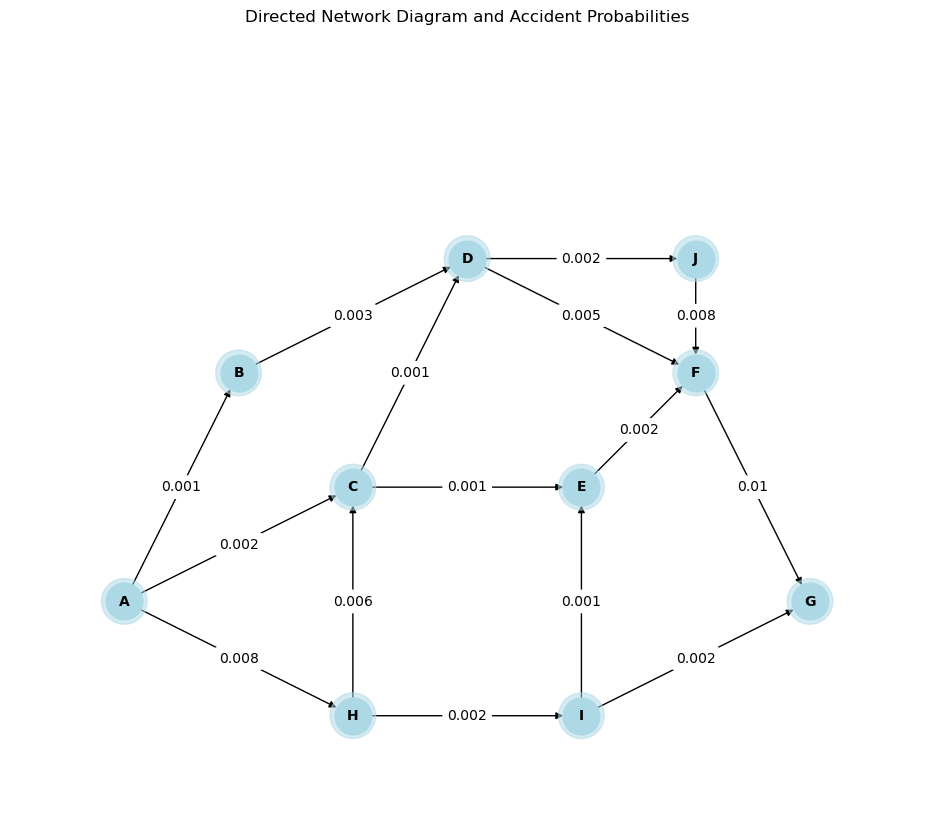

In [7]:
plt.figure(figsize=(10, 8))
nx.draw(G, pos=positions, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'Probability')

nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels, rotate=False)

# Draw circles around nodes
for node, (x, y) in positions.items():
    circle = mpatches.Circle((x, y), radius=0.2, color='lightblue', alpha=0.5)
    plt.gca().add_patch(circle)

# Set limits and aspect
plt.xlim(-1, 7)
plt.ylim(-2, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Directed Network Diagram and Accident Probabilities')
plt.grid()
plt.show()

Wir möchten die sicherste Route finden. Das bedeutet, daß die Wahrscheinlichkeit, **keinen** Unfall zu haben, maximiert werden soll. In dem Datensatz haben wir Wahrscheinlichkeiten für das Ereinis "Unfall" auf den einzelnen Straßen.

Bezeichnen wir mit $P(A_{s,e})$ die Wahrscheinlichkeiten, einen Unfall auf der Stracke mit Anfang $s$ und Ende $e$ zu haben. Die Unfälle passieren unabhängig auf den verschiedenen Stracken, deswegen ist die Wahrscheinlichkeit, **keinen** Unfall zu haben, das Produkt der Wahrscheinlichkeiten, **keinen** Unfall auf der einzelnen Strecke zu haben. 

$$
P(A_{s,e}^{c}) = 1 - P(A_{s,e})
$$

Die Wahrscheinlichkeit, **nirgendwo** einen Unfall zu haben, ist dann gegeben durch:

$$
P(\text{kein Unfall auf der Route}) = \prod_{s,e \in \text{Route}} (1 - P(A_{s,e}))
$$

Um die Aufgabe als ein lineares Modell zu formulieren, müssen wir diese Wahrscheinlichkeit linearisieren. Das ist hier ganz einfach, denn wir können den Logarithmus der Wahrscheinlichkeit nehmen. Dann gilt:

$$
\log(P(\text{kein Unfall auf der Route})) = \sum_{s,e \in \text{Route}} \log(1 - P(A_{s,e}))
$$

Z.B. wenn wir die Route $A \rightarrow H \rightarrow I \rightarrow G$ nehmen, dann ist die Wahrscheinlichkeit, **keinen** Unfall zu haben:

$$
\begin{align*}
P(\text{kein Unfall auf der Route}) & = (1 - P(A_{A,H})) \cdot (1 - P(A_{H,I})) \cdot (1 - P(A_{I,G})) \\
& (1 - 0.008) \cdot (1 - 0.002) \cdot (1 - 0.002) \\
& = 0.992 \cdot 0.998 \cdot 0.998 \\
& = 0.98803
\end{align*}
$$

Oder in logarithmischer Form:

$$
\begin{align*}
\log(P(\text{kein Unfall auf der Route})) & = \log(1 - P(A_{A,H})) + \log(1 - P(A_{H,I})) + \log(1 - P(A_{I,G})) \\
& = \log(0.992) + \log(0.998) + \log(0.998) \\
& = -0.00803217 + -0.002002 + -0.002002 \\
& = -0.01203617
\end{align*}
$$

$$
e^{\log(P(\text{kein Unfall auf der Route}))} = e^{-0.01203617} = 0.98803
$$

Die Zielfunktion ist also gegeben durch:

$$
\begin{align*}
\max \sum_{\forall s} \sum_{\forall e} x_{s,e} \log(1 - P(A_{s,e}))
\end{align*}
$$

Die Einschränkungen sind die gleichen wie bei der kürzesten Route.


In [8]:
probs = np.array([0.008, 0.002, 0.002])
np.exp(np.log((1 - probs)).sum())

np.float64(0.988035968)

In [ ]:
# Create a new model

dt["logProbability"] = np.log(1 - dt["Probability"])

m1 = gp.Model("ShortestPath with Accident Probabilities")

# Create variables for each edge

x = m1.addVars(dt.index, vtype=GRB.BINARY, name="x")

# Set the objective function to minimize the total distance
m1.setObjective(x.prod(dt['logProbability'].to_dict()), GRB.MAXIMIZE)

# Die Einschränkungen sind die gleichen wie oben

for node in nodes:
    if node == 'A':  # Start
        m1.addConstr(x.sum(node, '*') - x.sum('*', node) == 1, name=f"start_{node}")
    elif node == 'G':  # Ende
        m1.addConstr(x.sum('*', node) - x.sum(node, '*') == 1, name=f"end_{node}")
    else:
        m1.addConstr(x.sum(node, '*') - x.sum('*', node) == 0, name=f"flow_{node}")

# Add constraints to ensure that the flow is binary

m1.write("safest_path.lp")
with open("safest_path.lp", "r") as file:
    print(file.read())
    
m1.optimize()

\ Model ShortestPath with Accident Probabilities
\ LP format - for model browsing. Use MPS format to capture full model detail.
Maximize
  - 0.00100050033358353 x[A,B] - 0.00200200267067308 x[A,C]
   - 0.00300450902029872 x[B,D] - 0.00100050033358353 x[C,D]
   - 0.00100050033358353 x[C,E] - 0.00501254182354429 x[D,F]
   - 0.00200200267067308 x[E,F] - 0.0100503358535015 x[F,G]
   - 0.00803217169726427 x[A,H] - 0.00601807232556302 x[H,C]
   - 0.00200200267067308 x[H,I] - 0.00100050033358353 x[I,E]
   - 0.00200200267067308 x[I,G] - 0.00200200267067308 x[D,J]
   - 0.00803217169726427 x[J,F]
Subject To
 start_A: x[A,B] + x[A,C] + x[A,H] = 1
 flow_I: - x[H,I] + x[I,E] + x[I,G] = 0
 flow_E: - x[C,E] + x[E,F] - x[I,E] = 0
 flow_D: - x[B,D] - x[C,D] + x[D,F] + x[D,J] = 0
 flow_B: - x[A,B] + x[B,D] = 0
 flow_F: - x[D,F] - x[E,F] + x[F,G] - x[J,F] = 0
 flow_C: - x[A,C] + x[C,D] + x[C,E] - x[H,C] = 0
 flow_H: - x[A,H] + x[H,C] + x[H,I] = 0
 end_G: x[F,G] + x[I,G] = 1
 flow_J: - x[D,J] + x[J,F] = 0

In [13]:
# Print the results

if m1.status == GRB.OPTIMAL:
    print('Optimal solution found:')
    for v in m1.getVars():
        if v.x > 0:
            print(f'{v.varName}: {v.x}')
else:
    print('No optimal solution found.')

Optimal solution found:
x[A,H]: 1.0
x[H,I]: 1.0
x[I,G]: 1.0
